# Cosmic genome data

####  Introduction
 - The data is about the different type of cancer which occurs in human body
 
 - Types are :- 'NS', 'haematopoietic_and_lymphoid_tissue', 'ovary', 'cervix', 'endometrium', 'urinary_tract', 'kidney', 'pancreas', 'liver', 'large_intestine', 'lung', 'central_nervous_system', 'breast'

 - there are 13 classes so we will perform Multi_class Classification Problem
 
 - We will use log-loss as our performance-metric 



# data
 - https://drive.google.com/open?id=1cMg9RuLoWQigOItmCNdwpE_K4yX4ry7B

# importing package

In [1]:
#import all the necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import re
import math
import seaborn as sns
from collections import Counter
from matplotlib import gridspec
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# loading the data

In [2]:
data = pd.read_excel('COSMIC.xls')

In [3]:
print('Number of data points in train_set : ', data.shape[0])
print('Number of features in train_set: ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points in train_set :  65535
Number of features in train_set:  17
Features :  ['ID' 'ID_SAMPLE' 'ID_tumour' 'Primary site' 'Site subtype'
 'Primary histology' 'COUNT' 'Histology subtype' 'SAMPLE_NAME' 'TOTAL_CN'
 'MINOR_ALLELE' 'MUT_TYPE' 'COUNT.1' 'ID_STUDY' 'Chromosome' 'G_Start'
 'G_Stop']


,ID,ID_SAMPLE,ID_tumour,Primary site,Site subtype,Primary histology,COUNT,Histology subtype,SAMPLE_NAME,TOTAL_CN,MINOR_ALLELE,MUT_TYPE,COUNT.1,ID_STUDY,Chromosome,G_Start,G_Stop
0,1761589,1184078,1096043,breast,NS,carcinoma,1,NS,PD3890a,6.0,2.0,GAIN,1.0,385,1,171434331,209817057
1,1761645,1184078,1096043,breast,NS,carcinoma,1,NS,PD3890a,5.0,1.0,GAIN,1.0,385,12,150442,11493861
2,1761624,1184078,1096043,breast,NS,carcinoma,1,NS,PD3890a,5.0,1.0,GAIN,1.0,385,8,66854260,146298155
3,1761608,1184078,1096043,breast,NS,carcinoma,1,NS,PD3890a,6.0,2.0,GAIN,1.0,385,5,15532,3986495
4,1761659,1184078,1096043,breast,NS,carcinoma,1,NS,PD3890a,5.0,1.0,GAIN,1.0,385,16,68778996,75308899


In [4]:
unique_label = set(data['Primary site'])
print("Unique values in class_label",unique_label)

Unique values in class_label {'NS', 'haematopoietic_and_lymphoid_tissue', 'ovary', 'cervix', 'endometrium', 'urinary_tract', 'kidney', 'pancreas', 'liver', 'large_intestine', 'lung', 'central_nervous_system', 'breast'}


In [5]:
print(len(set(data['ID_SAMPLE'])))
print(len(set(data['ID_tumour'])))

2071
2071


##### "ID_SAMPLE" and "ID_tumour " gives same information so we drop "ID_SAMPLE"

In [6]:
data.drop(['ID_SAMPLE'],axis=1,inplace=True)

### changing notation,
'haematopoietic_and_lymphoid_tissue' : 0 <br>
                'lung': 1 <br>
              'urinary_tract' : 2 <br>
              'endometrium': 3 <br>
              'large_intestine' : 4 <br>
              'pancreas' : 5 <br>
              'NS' : 6 <br>
              'central_nervous_system' : 7 <br>
              'breast' : 8 <br>
              'cervix' : 9 <br>
              'liver' : 10 <br>
              'ovary' : 11 <br>
              'kidney' : 1 <br>

In [7]:
# creating dictionary of class label
class_dict = {'haematopoietic_and_lymphoid_tissue' : 0,
                'lung': 1,
              'urinary_tract' : 2,
              'endometrium': 3,
              'large_intestine' : 4,
              'pancreas' : 5,
              'NS' : 6,
              'central_nervous_system' : 7,
              'breast' : 8,
              'cervix' : 9,
              'liver' : 10,
              'ovary' : 11,
              'kidney' : 12}
class_label = []

for i in data['Primary site']:
    class_label.append(class_dict[i])


In [8]:
data.drop(['Primary site'],axis=1,inplace=True)
data['class'] = class_label

In [9]:
data.head(2)

,ID,ID_tumour,Site subtype,Primary histology,COUNT,Histology subtype,SAMPLE_NAME,TOTAL_CN,MINOR_ALLELE,MUT_TYPE,COUNT.1,ID_STUDY,Chromosome,G_Start,G_Stop,class
0,1761589,1096043,NS,carcinoma,1,NS,PD3890a,6.0,2.0,GAIN,1.0,385,1,171434331,209817057,8
1,1761645,1096043,NS,carcinoma,1,NS,PD3890a,5.0,1.0,GAIN,1.0,385,12,150442,11493861,8


In [10]:
# COUNT and COUNT.1 contains only one value which is 1, so this column is useless
#print(len(set(data['COUNT']))) = 1
#print(len(set(data['COUNT.1']))) = 1
data.drop(['COUNT'], axis=1, inplace=True)
data.drop(['COUNT.1'], axis=1, inplace=True)

## checking for missing values in data.


In [11]:
data.isnull().sum()

ID                       0
ID_tumour                0
Site subtype             0
Primary histology        0
Histology subtype        0
SAMPLE_NAME              0
TOTAL_CN                68
MINOR_ALLELE         28647
MUT_TYPE             28779
ID_STUDY                 0
Chromosome               0
G_Start                  0
G_Stop                   0
class                    0
dtype: int64

##### there are 68 values missing in TOTAL_CN
- as less number of data is missing we will impute mean values of that column there

In [12]:
n = (data.shape[0] - 68)
s = data['TOTAL_CN'].sum()
mean = math.floor(s/n)

val = []
for i in data['TOTAL_CN']:
    if np.isnan(i):
        val.append(mean)
    else:
        val.append(i)
        

In [13]:
data.drop(['TOTAL_CN'],axis=1,inplace=True)
data['TOTAL_CN'] = val

In [14]:
data['TOTAL_CN'].isnull().sum()

0

##### for  "MINOR_ALLELE "

In [15]:
s = set(data['MINOR_ALLELE'])
lst = list(data['MINOR_ALLELE'])
k = []
for i in s:
    if i == None:
        continue
    else:    
        k.append([i,lst.count(i)])
    

In [16]:
### top 5 count is
k[:5]

[[0.0, 16059], [1.0, 5768], [2.0, 8058], [3.0, 3433], [4.0, 1916]]

##### we impute "0" for the missing values as we have more count of "0"

In [17]:
val = []
for i in data['MINOR_ALLELE']:
    if np.isnan(i):
        val.append(0)
    else:
        val.append(i)

In [18]:
data.drop(['MINOR_ALLELE'],axis=1,inplace=True)
data['MINOR_ALLELE'] = val

In [19]:
data['MINOR_ALLELE'].isnull().sum()

0

##### for  "MUT_TYPE"

In [20]:
count_loss = 0
count_gain = 0
for i in data['MUT_TYPE']:
    if i == "LOSS":
        count_loss += 1
    elif i == "GAIN":
        count_gain += 1
    else:
        continue
        
print("loss_count is",count_loss)
print("gain_count is",count_gain)

loss_count is 13476
gain_count is 23280


###### so we can impute "GAIN" for the missing value as its count is much greater than "LOSS"
- here we use mode method to fill my missing values

In [21]:
val = []
for i in data['MUT_TYPE']:
    if type(i) == str:
        val.append(i)
    else:
        val.append("GAIN")

In [22]:
data.drop(['MUT_TYPE'],axis=1,inplace=True)
data['MUT_TYPE'] = val

In [23]:
data['MUT_TYPE'].isnull().sum()

0

In [24]:
data.isnull().sum()

ID                   0
ID_tumour            0
Site subtype         0
Primary histology    0
Histology subtype    0
SAMPLE_NAME          0
ID_STUDY             0
Chromosome           0
G_Start              0
G_Stop               0
class                0
TOTAL_CN             0
MINOR_ALLELE         0
MUT_TYPE             0
dtype: int64

##### no values is now missing : )

In [25]:
## checking categorical data and its lenght and distribution

for col in data.columns:
    print("column name : {}, length/distribution: {}".format(col,len(set(data[col]))))

column name : ID, length/distribution: 65535
column name : ID_tumour, length/distribution: 2071
column name : Site subtype, length/distribution: 6
column name : Primary histology, length/distribution: 6
column name : Histology subtype, length/distribution: 12
column name : SAMPLE_NAME, length/distribution: 2056
column name : ID_STUDY, length/distribution: 18
column name : Chromosome, length/distribution: 24
column name : G_Start, length/distribution: 57471
column name : G_Stop, length/distribution: 57270
column name : class, length/distribution: 13
column name : TOTAL_CN, length/distribution: 108
column name : MINOR_ALLELE, length/distribution: 29
column name : MUT_TYPE, length/distribution: 2


### conclusion of categorical data
##### for categorical data we perform one hot encoding
- Site subtype  = 6
- Primary histology  = 7
- Histology subtype  = 13
- MUT_TYPE  = 2
- ID_tumour  = 2071
- SAMPLE_NAME  = 2056


In [26]:
val = []
for i in data['ID_tumour']:
    val.append(str(i))

data.drop(['ID_tumour'],axis=1,inplace=True)
data['ID_tumour'] = val

In [27]:
val = []
for i in data['SAMPLE_NAME']:
    val.append(str(i))

data.drop(['SAMPLE_NAME'],axis=1,inplace=True)
data['SAMPLE_NAME'] = val

#### Before vectorization of categorical data we need to split our data for training and testing
- we perform random Splitting

In [28]:
Y = data['class']
data.drop(['class'],axis=1,inplace=True)
X = data
train_data, test_data, train_y, test_y = train_test_split(X, Y, test_size=0.20, stratify=Y)

In [29]:
print(train_data.shape, train_y.shape)
print(test_data.shape, test_y.shape)

(52428, 13) (52428,)
(13107, 13) (13107,)


### Distribution of Class_label

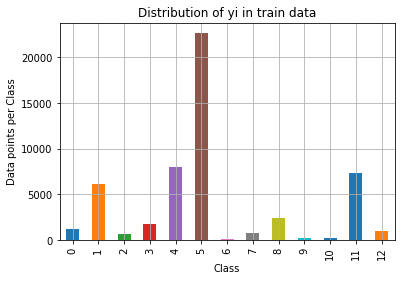

Number of data points in class 6 : 22658 ( 43.217 %)
Number of data points in class 5 : 8030 ( 15.316 %)
Number of data points in class 12 : 7330 ( 13.981 %)
Number of data points in class 2 : 6078 ( 11.593 %)
Number of data points in class 9 : 2466 ( 4.704 %)
Number of data points in class 4 : 1781 ( 3.397 %)
Number of data points in class 1 : 1172 ( 2.235 %)
Number of data points in class 13 : 954 ( 1.82 %)
Number of data points in class 8 : 728 ( 1.389 %)
Number of data points in class 3 : 703 ( 1.341 %)
Number of data points in class 11 : 205 ( 0.391 %)
Number of data points in class 10 : 189 ( 0.36 %)
Number of data points in class 7 : 134 ( 0.256 %)
--------------------------------------------------------------------------------


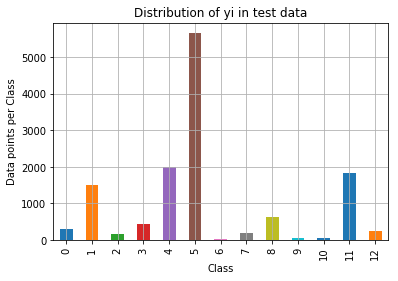

Number of data points in class 6 : 5665 ( 43.221 %)
Number of data points in class 5 : 2008 ( 15.32 %)
Number of data points in class 12 : 1832 ( 13.977 %)
Number of data points in class 2 : 1519 ( 11.589 %)
Number of data points in class 9 : 617 ( 4.707 %)
Number of data points in class 4 : 445 ( 3.395 %)
Number of data points in class 1 : 293 ( 2.235 %)
Number of data points in class 13 : 239 ( 1.823 %)
Number of data points in class 8 : 182 ( 1.389 %)
Number of data points in class 3 : 176 ( 1.343 %)
Number of data points in class 11 : 51 ( 0.389 %)
Number of data points in class 10 : 47 ( 0.359 %)
Number of data points in class 7 : 33 ( 0.252 %)


In [30]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_y.value_counts().sortlevel()
test_class_distribution = test_y.value_counts().sortlevel()

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_data.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_data.shape[0]*100), 3), '%)')


###### class distribution is preserved in splitting of data

In [31]:
export_train = train_data.to_csv('data/train.csv')
export_test = test_data.to_csv('data/test.csv')
export_train_y = train_y.to_csv('data/train_label.csv')
export_test_y = test_y.to_csv('data/test_label.csv')

### Vectorization of  Categorical Data 

In [32]:
# Site subtype
vectorizer = CountVectorizer()
vectorizer.fit(train_data['Site subtype'].values)
train_site_subtype_ohe = vectorizer.transform(train_data['Site subtype'].values)
test_site_subtype_ohe = vectorizer.transform(test_data['Site subtype'].values)
print(vectorizer.get_feature_names())
print()
print("After vectorizations")

print(train_site_subtype_ohe.shape, train_y.shape)
print(test_site_subtype_ohe.shape, test_y.shape)

['bladder', 'brain', 'caecum', 'colon', 'ns', 'rectum']

After vectorizations
(52428, 6) (52428,)
(13107, 6) (13107,)


In [33]:
# Primary histology
vectorizer = CountVectorizer()
vectorizer.fit(train_data['Primary histology'].values)
train_Primary_histology_ohe = vectorizer.transform(train_data['Primary histology'].values)
test_Primary_histology_ohe = vectorizer.transform(test_data['Primary histology'].values)
print(vectorizer.get_feature_names())
print()
print("After vectorizations")

print(train_Primary_histology_ohe.shape, train_y.shape)
print(test_Primary_histology_ohe.shape, test_y.shape)

['carcinoma', 'glioma', 'haematopoietic_neoplasm', 'lymphoid_neoplasm', 'medulloblastoma', 'ns', 'primitive_neuroectodermal_tumour']

After vectorizations
(52428, 7) (52428,)
(13107, 7) (13107,)


In [34]:
# Histology subtype

vectorizer = CountVectorizer()
vectorizer.fit(train_data['Histology subtype'].values)
train_Histology_subtype_ohe = vectorizer.transform(train_data['Histology subtype'].values)
test_Histology_subtype_ohe = vectorizer.transform(test_data['Histology subtype'].values)
print(vectorizer.get_feature_names())
print()
print("After vectorizations")

print(train_Histology_subtype_ohe.shape, train_y.shape)
print(test_Histology_subtype_ohe.shape, test_y.shape)

['acute_myeloid_leukaemia', 'adenocarcinoma', 'astrocytoma_grade_iv', 'chronic_lymphocytic_leukaemia', 'clear_cell_renal_cell_carcinoma', 'ductal_carcinoma', 'endometrioid_carcinoma', 'hepatocellular_carcinoma', 'large_cell', 'ns', 'serous_carcinoma', 'small_lymphocytic_lymphoma', 'squamous_cell_carcinoma']

After vectorizations
(52428, 13) (52428,)
(13107, 13) (13107,)


In [35]:
# MUT_TYPE

vectorizer = CountVectorizer()
vectorizer.fit(train_data['MUT_TYPE'].values)
train_mut_type_ohe = vectorizer.transform(train_data['MUT_TYPE'].values)
test_mut_type_ohe = vectorizer.transform(test_data['MUT_TYPE'].values)
print(vectorizer.get_feature_names())
print()
print("After vectorizations")

print(train_mut_type_ohe.shape, train_y.shape)
print(test_mut_type_ohe.shape, test_y.shape)

['gain', 'loss']

After vectorizations
(52428, 2) (52428,)
(13107, 2) (13107,)


In [36]:
# ID_tumour
vectorizer = CountVectorizer()
vectorizer.fit(train_data['ID_tumour'].values)
train_id_tumour_ohe = vectorizer.transform(train_data['ID_tumour'].values)
test_id_tumour_ohe = vectorizer.transform(test_data['ID_tumour'].values)
print()
print("After vectorizations")

print(train_id_tumour_ohe.shape, train_y.shape)
print(test_id_tumour_ohe.shape, test_y.shape)


After vectorizations
(52428, 2020) (52428,)
(13107, 2020) (13107,)


In [37]:
# SAMPLE_NAME
vectorizer = CountVectorizer()
vectorizer.fit(train_data['SAMPLE_NAME'].values)
train_sample_name_ohe = vectorizer.transform(train_data['SAMPLE_NAME'].values)
test_sample_name_ohe = vectorizer.transform(test_data['SAMPLE_NAME'].values)
print()
print("After vectorizations")

print(train_sample_name_ohe.shape, train_y.shape)
print(test_sample_name_ohe.shape, test_y.shape)


After vectorizations
(52428, 2140) (52428,)
(13107, 2140) (13107,)


In [38]:
train_data.drop(['Site subtype','Primary histology','Histology subtype','MUT_TYPE','ID_tumour','SAMPLE_NAME'],axis=1,inplace=True)
test_data.drop(['Site subtype','Primary histology','Histology subtype','MUT_TYPE','ID_tumour','SAMPLE_NAME'],axis=1,inplace=True)

### Normalizing the whole data.
- helps in getting rid of scale

In [39]:
# train
train_data = normalize(train_data)

In [40]:
# test
test_data = normalize(test_data)

### concatenating all the data:-


In [41]:

x_train = hstack((train_data,train_site_subtype_ohe,train_Primary_histology_ohe,train_Histology_subtype_ohe,train_mut_type_ohe,train_id_tumour_ohe,train_sample_name_ohe)).tocsr() 
x_test = hstack((test_data,test_site_subtype_ohe,test_Primary_histology_ohe,test_Histology_subtype_ohe,test_mut_type_ohe,test_id_tumour_ohe,test_sample_name_ohe)).tocsr()

In [42]:
print(x_train.shape,train_y.shape)
print(x_test.shape,test_y.shape)

(52428, 4195) (52428,)
(13107, 4195) (13107,)


In [43]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
   
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(18,12))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(18,12))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(18,12))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Performing Logistic regression for multi-class classification

In [ ]:
lr =LogisticRegression()
prams={'C':[10**i for i in range(-4,5)]}
random_clf = RandomizedSearchCV(lr,prams,scoring='neg_log_loss',cv=5,n_jobs=-1)
random_clf.fit(x_train,train_y)

In [68]:
random_clf.best_params_

{'C': 10000}

In [ ]:
x_clf = LogisticRegression(C = 10000)
x_clf.fit(x_train,train_y)
c_cfl=CalibratedClassifierCV(x_clf,method='sigmoid')
c_cfl.fit(x_train,train_y)

## train_data confusion_matrix

train loss 0.0008862798966214478
-------------------- Confusion matrix --------------------


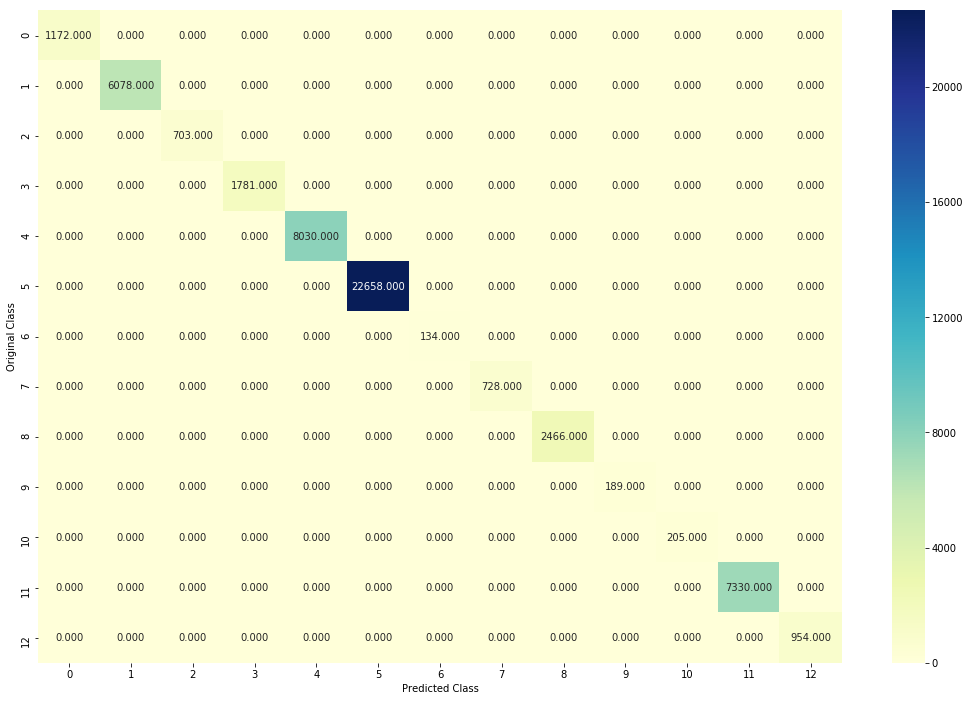

-------------------- Precision matrix (Columm Sum=1) --------------------


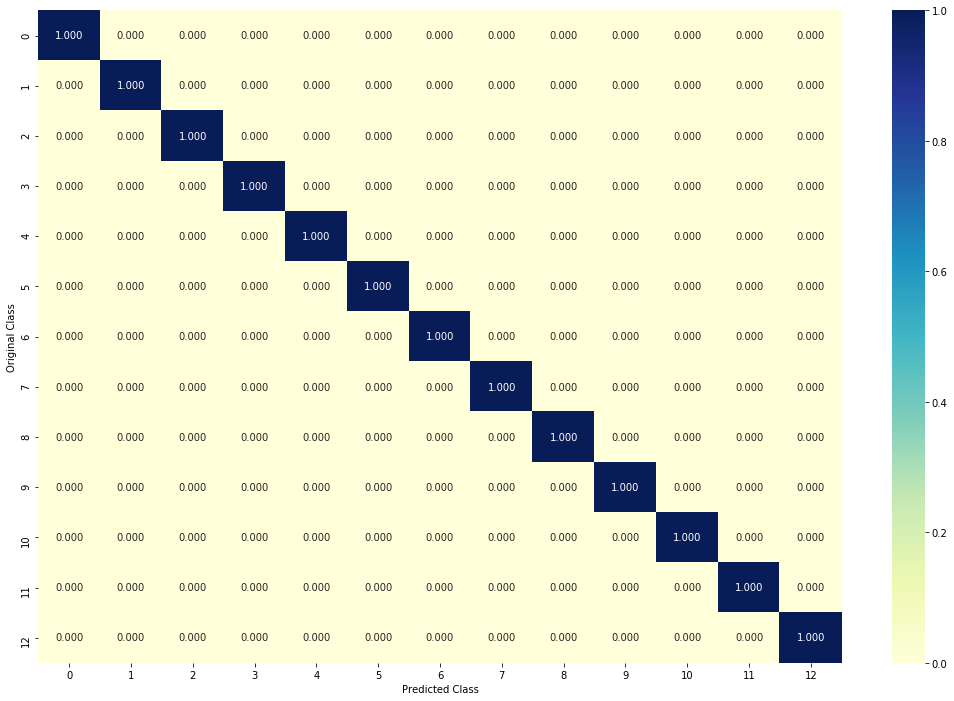

-------------------- Recall matrix (Row sum=1) --------------------


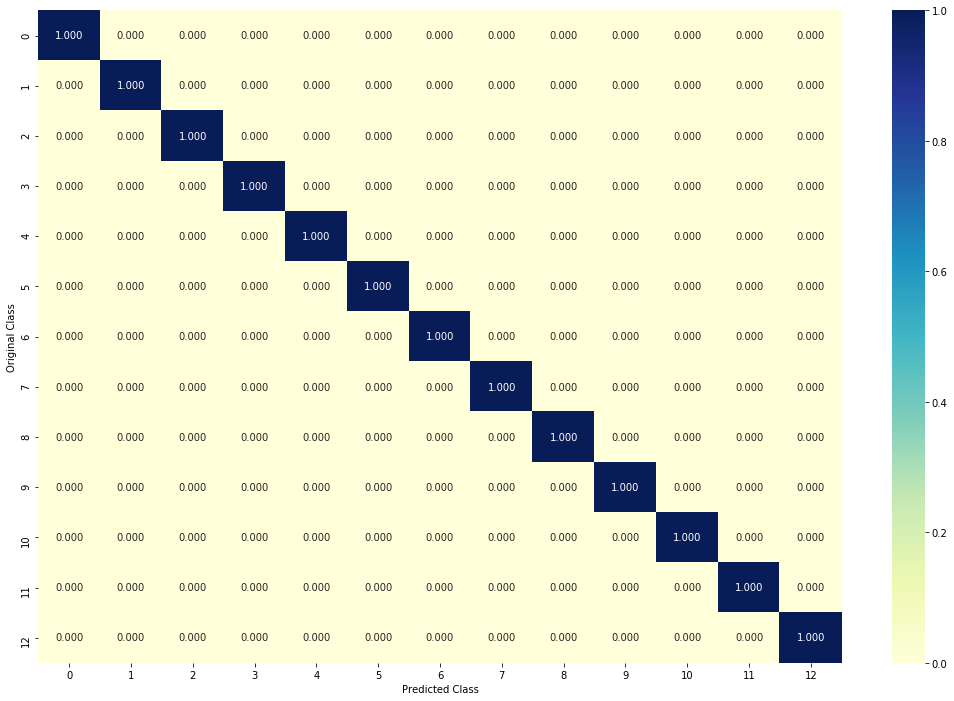

In [70]:
predict_y = c_cfl.predict_proba(x_train)
print ('train loss',log_loss(train_y, predict_y))
plot_confusion_matrix(train_y,c_cfl.predict(x_train))


## test_data confusion matrix

test loss 0.0009788474715784698
-------------------- Confusion matrix --------------------


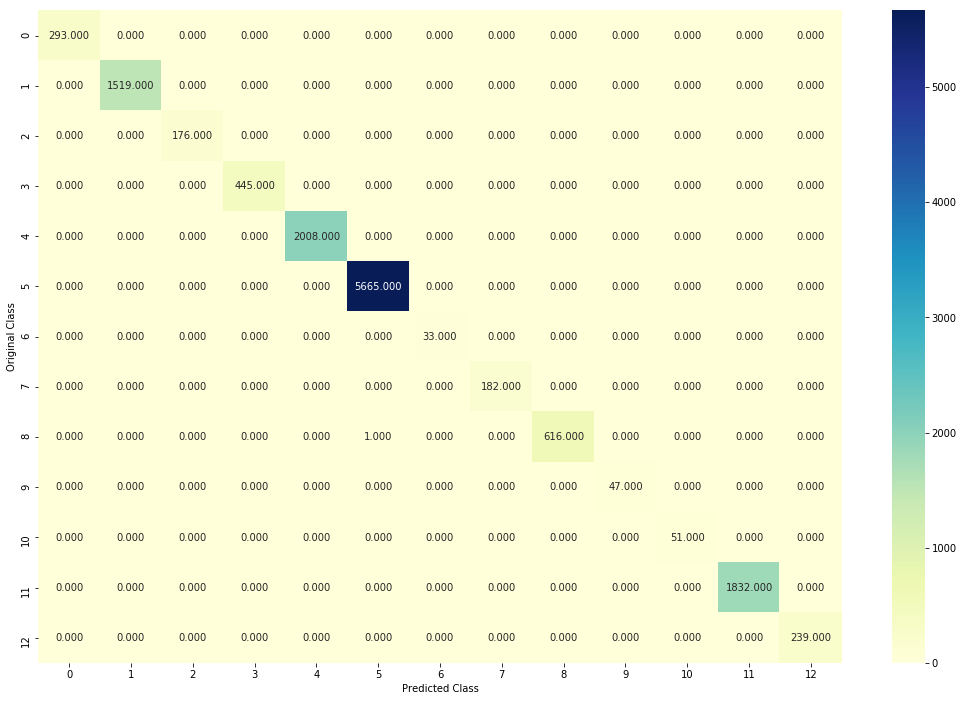

-------------------- Precision matrix (Columm Sum=1) --------------------


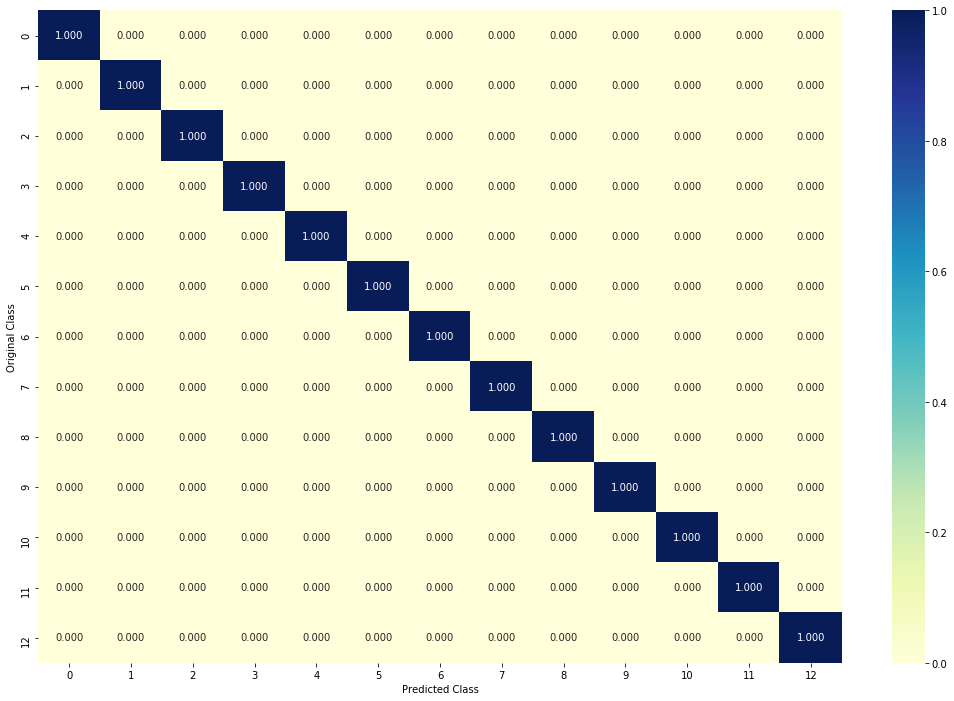

-------------------- Recall matrix (Row sum=1) --------------------


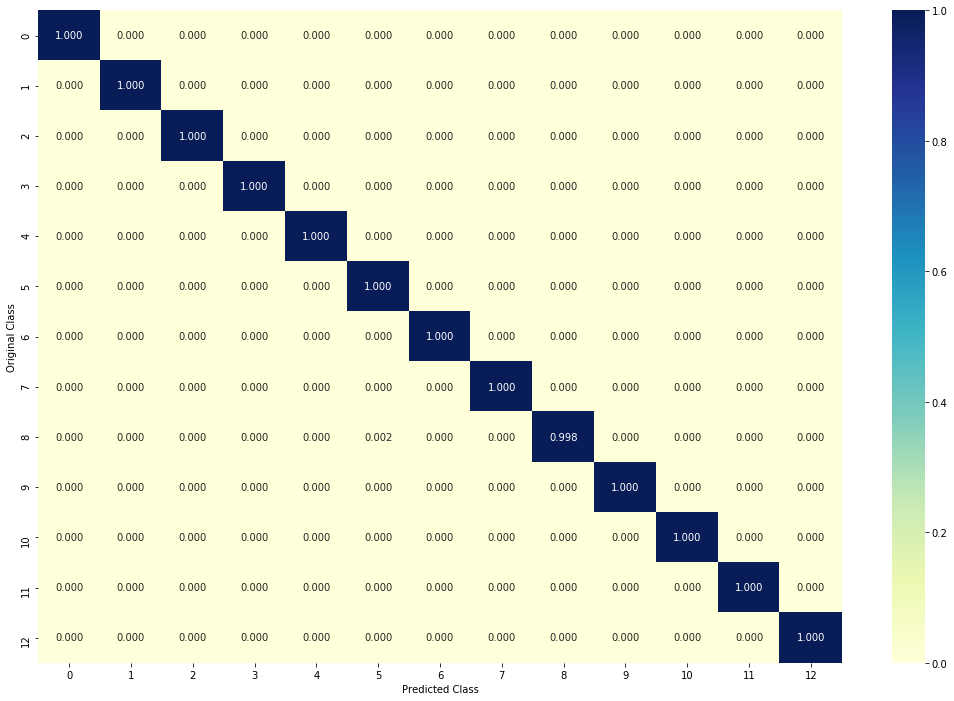

In [71]:
predict_y = c_cfl.predict_proba(x_test)
print ('test loss',log_loss(test_y, predict_y))
plot_confusion_matrix(test_y,c_cfl.predict(x_test))

In [72]:
# save the model to disk
filename = 'model_logistic_reg.sav'
pickle.dump(c_cfl, open(filename, 'wb'))


# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

## Performing xgboost for binary multi-class classification

In [ ]:
x_cfl=XGBClassifier()
prams={'n_estimators':[10,50,100,200],
     'max_depth':[5,10,20,50]}
random_clf = RandomizedSearchCV(x_cfl,prams,scoring='neg_log_loss',cv=5,n_jobs=-1)
random_clf.fit(x_train,train_y)

In [ ]:
random_clf.best_params_

_Best parameters are:-_
- __max_depth = 20__
- __n_estimators = 200__

In [ ]:
x_clf = XGBClassifier(n_estimators=200,max_depth=20)
x_clf.fit(x_train,train_y)
c_cfl=CalibratedClassifierCV(x_clf,method='sigmoid')
c_cfl.fit(x_train,train_y)


## train_data confusion_matrix

train loss 0.001102724774878895
-------------------- Confusion matrix --------------------


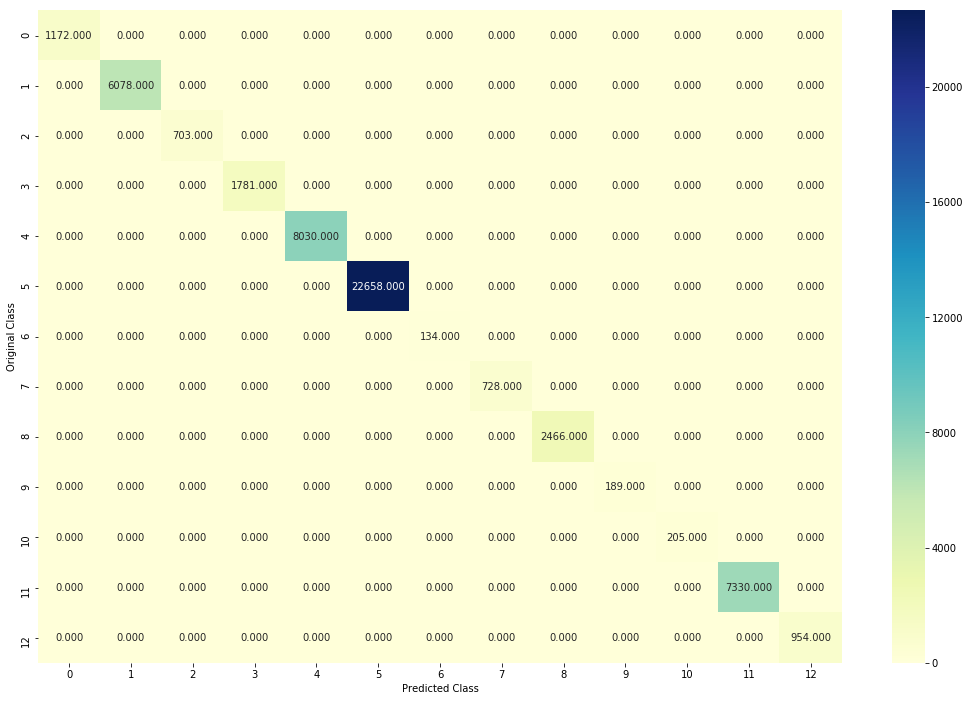

-------------------- Precision matrix (Columm Sum=1) --------------------


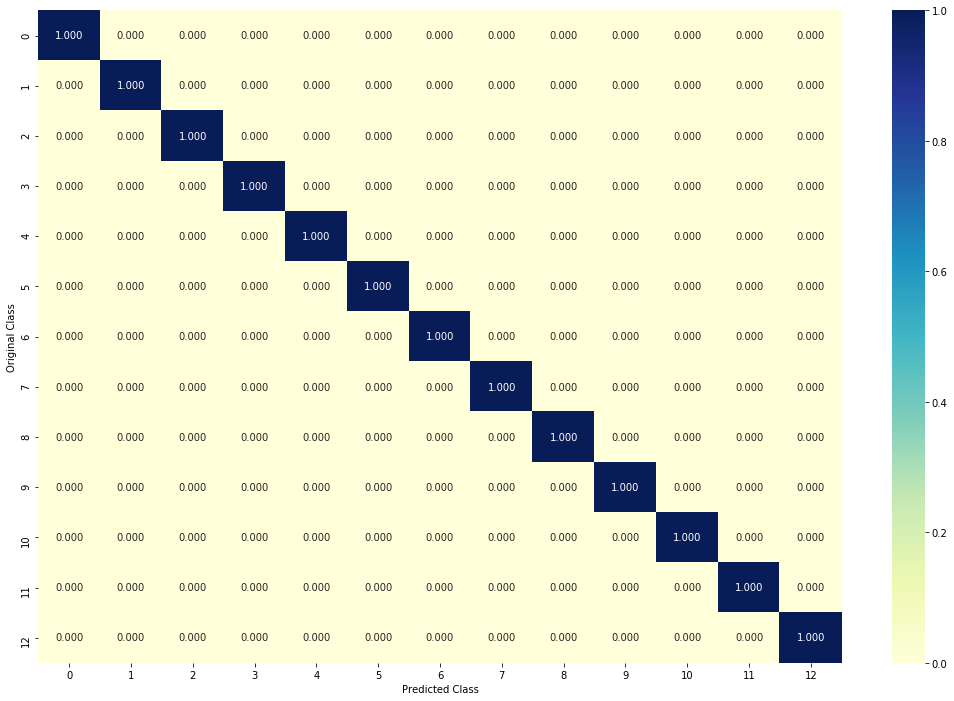

-------------------- Recall matrix (Row sum=1) --------------------


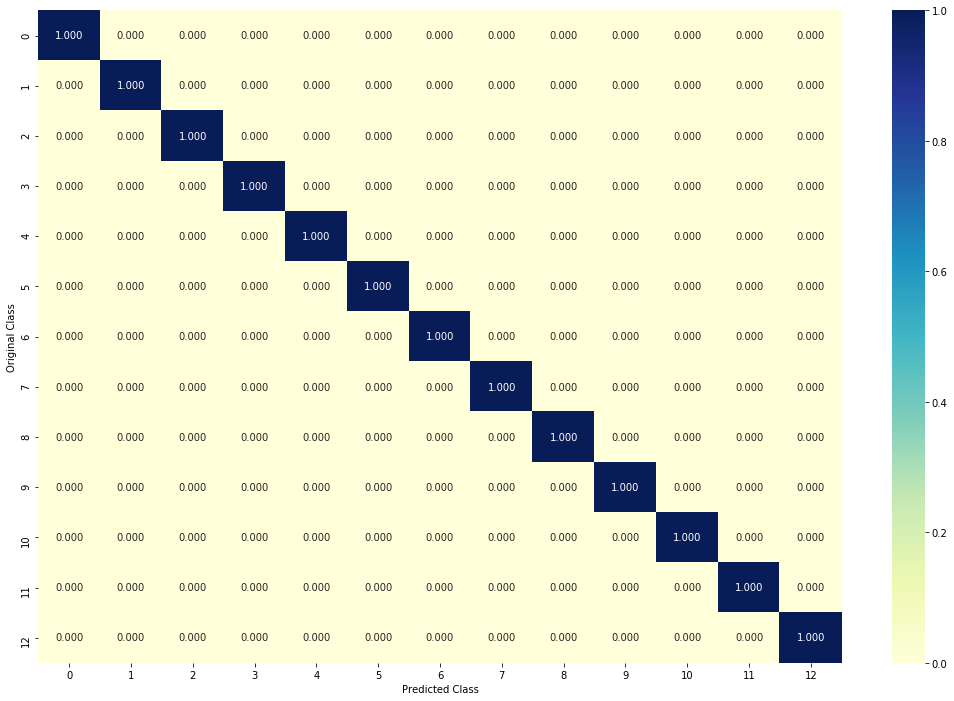

In [66]:

predict_y = c_cfl.predict_proba(x_train)
print ('train loss',log_loss(train_y, predict_y))
plot_confusion_matrix(train_y,c_cfl.predict(x_train))


## test_data confusion_matrix

test loss 0.001324805547767181
-------------------- Confusion matrix --------------------


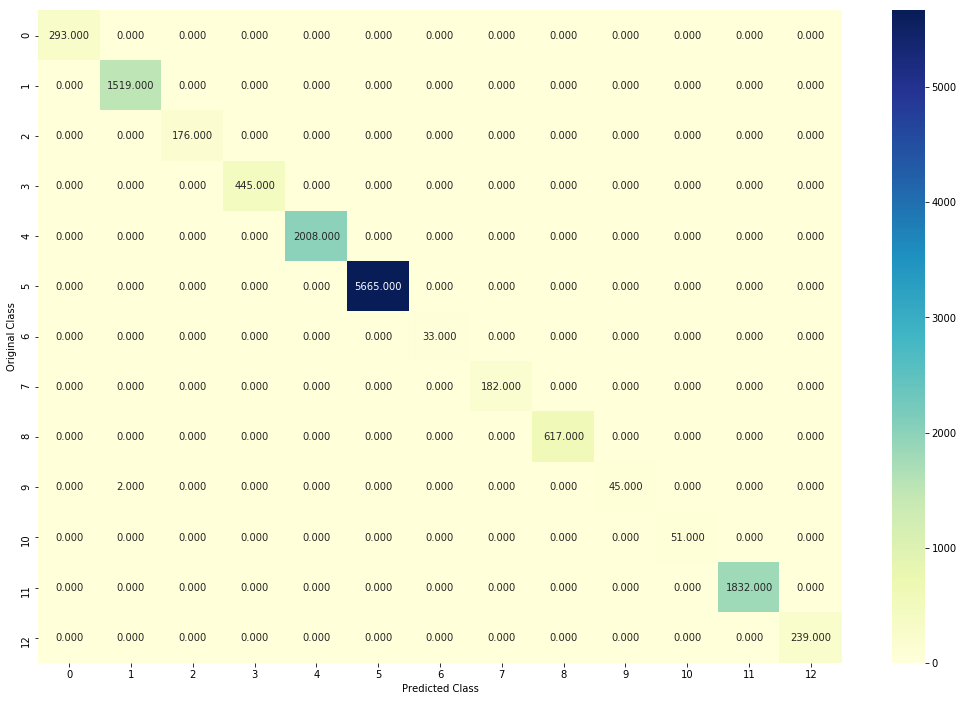

-------------------- Precision matrix (Columm Sum=1) --------------------


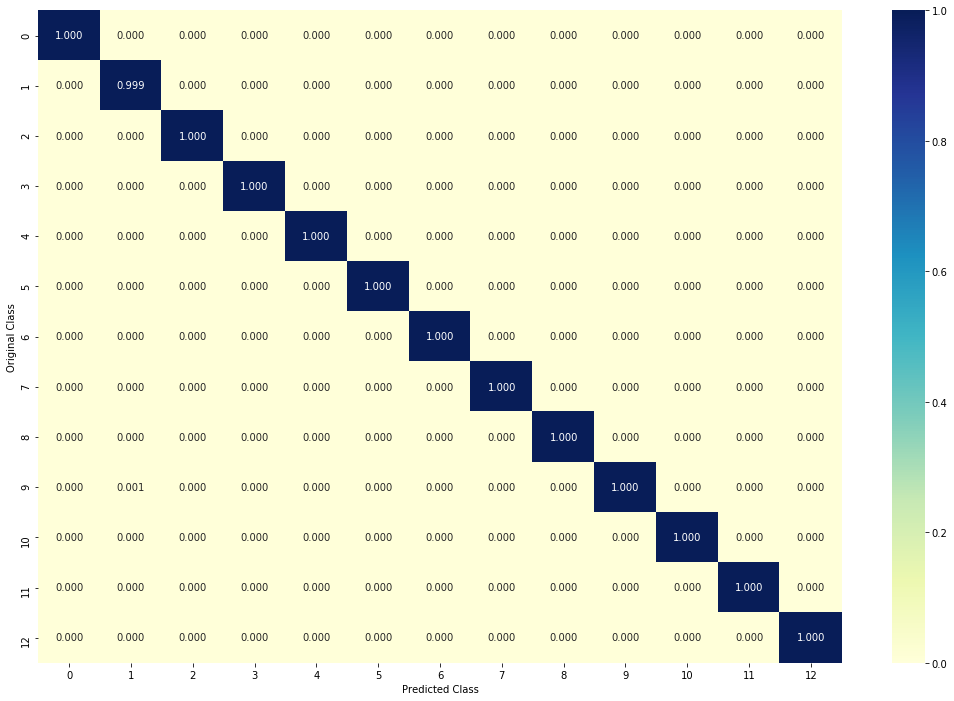

-------------------- Recall matrix (Row sum=1) --------------------


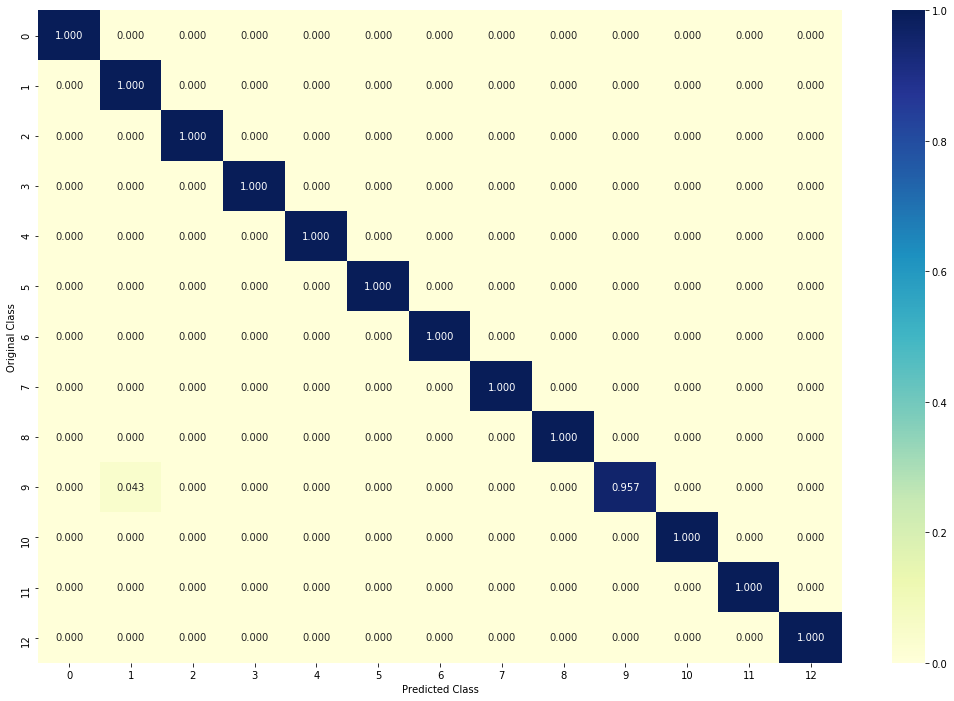

In [67]:
predict_y = c_cfl.predict_proba(x_test)
print ('test loss',log_loss(test_y, predict_y))
plot_confusion_matrix(test_y,c_cfl.predict(x_test))

In [ ]:
# save the model to disk
filename = 'model_xgboost.sav'
pickle.dump(c_cfl, open(filename, 'wb'))


# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))